<div>
    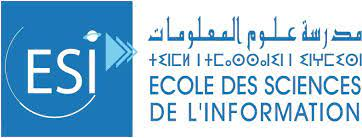
</div>

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:orange;font-weight:bold"><u>Réalisé par:</u></p>
<ul >
    <li>ELGHAZI Soufiane</li>
    <li>MAASRI Amine</li>
    <li>Dahmou Youssef</li>
    <li>OUAHIB Yassine</li>
</ul>
    
</div>

<h1 style='color:purple' align='center'>Projet Text mining: News SUM </h1>

<h2 style='color:olive' align='center'>BART </h2>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:purple;">Étape 2 : Création et évaluation des modèles : BART</p><br>
<p style="color:purple;">Références</p>
 Les liens vers les ressources utilisées et consulté .<br><br>
</div>

<h2 style='color:purple'>Importation des Bibliothèques: </h2>

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cleaned-dataset/cleaned_corpus.xlsx


In [2]:
!nvidia-smi # Checking GPU

Sat Dec 30 02:31:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [3]:
#!pip install datasets # Installing the datasets library (https://huggingface.co/docs/datasets/index)
!pip install evaluate # Installing the evaluate library (https://huggingface.co/docs/evaluate/main/en/index)
!pip install transformers # Installing the transformers library (https://huggingface.co/docs/transformers/index)
!pip install rouge-score # Installing rouge-score library (https://pypi.org/project/rouge-score/)
!pip install py7zr # Installing library to save zip archives (https://pypi.org/project/py7zr/)

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 891.0 kB/s eta 0:00:000:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=ed668e33125f9a8b6a05bc43a1cb463404b43ae167cef7a67a93e1116d392e85
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Obtaining dependency information for py7zr from https://files.pythonhosted.org/packages/c0/39/71263be4c6081e1788f4da35e937fca1808914b0d98a04bd44255b948699/py7zr-0.20.8-py3-none-any.whl.metadata
  Obtaining dependency information for pycryptodomex>=3.16.0 from https://files.pythonhosted.org/packages/78/74/e22cc8c2bb5e4d746952b22a2f0ef98988851804c35d89890d8ea6c22f18/pycr

In [4]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_metric
import shutil

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              # PyTorch
import evaluate                                                           # Hugging Face's library for model evaluation


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')                                                    # This divides a text into a list of sentences

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
pd.set_option('display.max_colwidth', 1000)
# Configuring notebook
seed = 42
colormap = 'cividis'
template = 'plotly_dark'
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
TF-IDF
</div>

In [8]:
def compute_tfidf(df_column, ngram_range=(1,1), max_features=15):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram_range)
    x = vectorizer.fit_transform(df_column.fillna(''))
    df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
    return df_tfidfvect

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
importer le jeu de données
</div>

In [9]:
from sklearn.model_selection import train_test_split

data_path = '/kaggle/input/cleaned-dataset/cleaned_corpus.xlsx'
df = pd.read_excel(data_path)

In [10]:
df =  df[['Content_preprocessed','Summary_preprocessed']]
df.head()

,Content_preprocessed,Summary_preprocessed
0,severe storms and at least one tornado slammed through central tennessee killing 24 people and wrecking hundreds of buildings hours before dawn on tuesday it s tragic day in our state gov bill lee told reporters it s heartbreaking. initial surveys indicated ef-3 tornado damage in east nashville nashville s donelson neighborhood and in mt juliet town about 20 miles east of nashville the national weather service said among the victims was couple who was hit by debris shortly after they left the attaboy lounge an east nashville cocktail bar where one of them worked the metro nashville police department said they were identified as michael dolfini 36 and his girlfriend albree sexton 33 as of tuesday evening 18 people were reported dead in putnam county three in wilson county two in davidson county and one in benton county the tennessee emergency management authority said the agency said one death previously reported in putnam county was not storm related putnam county officials have...,it s heartbreaking. initial surveys indicated ef-3 tornado damage in east nashville nashville s donelson neighborhood and in mt as of tuesday evening 18 people were reported dead in putnam county three in wilson county two in davidson county and one in benton county the tennessee emergency management authority said robin fugett and her husband ran to the basement of their east nashville home early tuesday when they heard swirling wind in davidson county where nashville is and wilson county voting was delayed one hour because of the storms officials said wtvfmetro nashville public schools are closed due to tornado damage throughout the city the district said.
1,by the time the tornado siren sounded one week ago the roof of sydney moore s mobile home in clarksville tennessee had been sheared off and her 4-month-old son lord sucked up by the twister there was no warning said moore 22 who immediately moved to shield her 1-year-old son princeton with her body moore s boyfriend aramis youngblood 39 rushed to protect lord who was sleeping in bassinet swept up in swirl of wind and debris saturday evening as series of powerful tornadoes and storms tore through the state the walls of moore s mobile home came down next the roar of shredding winds was punctuated by pounding rains youngblood reaching for the bassinet also was lifted off the ground and hurtled through the air moore recalled moore cradling her 1-year-old son climbed out from beneath the remains of the crushed mobile home my kids never cry they re such good babies she said i was trying to get us out he wasn t even crying. youngblood his shoulder dislocated spent an agonizing 10 minu...,by the time the tornado siren sounded one week ago the roof of sydney moore s mobile home in clarksville tennessee had been sheared off and her 4-month-old son lord sucked up by the twister moments before the clarksville tornado touched down moore youngblood and the boys were relaxing in her mobile home tornado passes in front of storm chasers in clarksville tennessee last saturday it s really so comforting sydney moore said like an angel guided him safely to that spot. in an interview caitlyn moore said it s miracle lord is alive.
2,severe storms and at least one tornado slammed through central tennessee killing 24 people and wrecking hundreds of buildings hours before dawn on tuesday it s tragic day in our state gov bill lee told reporters it s heartbreaking. initial surveys indicated ef-3 tornado damage in east nashville nashville s donelson neighborhood and in mt juliet town about 20 miles east of nashville the national weather service said among the victims was couple who was hit by debris shortly after they left the attaboy lounge an east nashville cocktail bar where one of them worked the metro nashville police department said they were identified as michael dolfini 36 and his girlfriend albree sexton 33 as of tuesday evening 18 people were reported dead in putnam c

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Split the data
</div>

In [11]:
# Split the data into train, validation, and test sets
train, temp_data = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(temp_data, test_size=0.5, random_state=42)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Transformation de dataframes vers datasets
</div>

In [12]:
# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)
val_ds = Dataset.from_pandas(val)

# Visualizing results
print(train_ds)
print('\n' * 2)
print(test_ds)
print('\n' * 2)
print(val_ds)

Dataset({
    features: ['Content_preprocessed', 'Summary_preprocessed', '__index_level_0__'],
    num_rows: 1514
})



Dataset({
    features: ['Content_preprocessed', 'Summary_preprocessed', '__index_level_0__'],
    num_rows: 190
})



Dataset({
    features: ['Content_preprocessed', 'Summary_preprocessed', '__index_level_0__'],
    num_rows: 189
})


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Modelisation et création de modèle BART
</div>

In [13]:
checkpoint = 'facebook/bart-large-xsum' # Model
tokenizer = BartTokenizer.from_pretrained(checkpoint) # Loading Tokenizer

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

In [14]:
model = BartForConditionalGeneration.from_pretrained(checkpoint) # Loading Model

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

In [15]:
print(model) # Visualizing model's architecture

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Fonction de preprocessing avec bart tokenizer
</div>

In [16]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["Content_preprocessed"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["Summary_preprocessed"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [17]:
# Applying preprocess_function to the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=[ 'Content_preprocessed', 'Summary_preprocessed']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=[ 'Content_preprocessed', 'Summary_preprocessed']) # Removing features

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['Content_preprocessed', 'Summary_preprocessed']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)
print('\n' * 2)
print('Preprocessed Test Dataset:\n')
print(tokenized_test)
print('\n' * 2)
print('Preprocessed Validation Dataset:\n')
print(tokenized_val)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]





Preprocessed Training Dataset:

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1514
})



Preprocessed Test Dataset:

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 190
})



Preprocessed Validation Dataset:

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 189
})


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Choisir un exemple de dataset
</div>

In [18]:
# Selecting a sample from the dataset
sample = tokenized_train[0]

# Printing its features
print("input_ids:")
print(sample['input_ids'])
print("\n")
print("attention_mask:")
print(sample['attention_mask'])
print("\n")
print("sample:")
print(sample['labels'])
print("\n")

input_ids:
[0, 3340, 43341, 1499, 24433, 3215, 11, 5, 935, 23, 5, 593, 9, 8835, 77, 2458, 992, 21028, 2865, 851, 201, 11986, 88, 5, 32820, 15189, 1778, 9468, 6500, 149, 6229, 2015, 30845, 14, 5026, 7, 1045, 13618, 1472, 9, 2166, 2621, 11, 14241, 523, 4348, 6229, 11534, 25, 15180, 11, 8157, 52, 6957, 23490, 9, 773, 11, 6229, 2015, 17959, 258, 8354, 8, 27499, 24506, 150, 5, 32820, 15189, 26158, 773, 11, 8157, 24, 21, 45, 5, 129, 26408, 1370, 23, 310, 5, 6986, 9, 20181, 3693, 10, 118, 56, 15682, 15992, 5, 6981, 1056, 11, 32820, 15189, 8, 20181, 3693, 10, 118, 25954, 154, 5, 499, 9, 1050, 12, 36327, 10405, 1437, 811, 16531, 5065, 8, 2628, 13637, 449, 4891, 3922, 8157, 8, 291, 1922, 33, 57, 1605, 515, 2650, 107, 11, 1402, 9836, 9, 7350, 2316, 150, 203, 9, 10, 118, 8, 3563, 2239, 34, 57, 7397, 409, 31, 4007, 285, 1503, 62, 7, 122, 5, 937, 804, 1956, 34, 6017, 57, 441, 7, 4949, 19, 739, 2777, 3092, 19385, 4339, 1241, 33285, 215, 25, 490, 1439, 7359, 571, 3320, 8, 39121, 741, 1120, 42, 709, 21

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Initialiser data collator
</div>

In [19]:
# Instantiating Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [20]:
metric = load_metric('rouge') # Loading ROUGE Score

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Fonction de calcul des métrics
</div>

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels
    
    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    
    # Computing rouge score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()} # Extracting some results

    # Add mean-generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [22]:
# Example for memory profiling with PyTorch
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Définir les paramétres d'entrainement et entrainer le modèle
</div>

In [23]:
training_args = Seq2SeqTrainingArguments(
    output_dir = 'bart_samsum',
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    seed = seed,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

In [24]:
# Defining Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [25]:
#trainer.train() # Training model
train_history = trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,No log,1.438764,41.596400,24.769800,33.579500,33.510800,49.842100
1,No log,1.424027,42.204900,24.730900,33.804900,33.785900,51.536800
2,No log,1.450958,43.189200,25.858100,34.700000,34.670600,53.815800
3,No log,1.465277,42.776100,25.472600,34.219900,34.189800,53.452600


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Générer les résumés</div>

In [26]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer

def generate_summary(text, model, tokenizer, max_length=150, min_length=50):
    device = next(model.parameters()).device  # Get the device of the model
    inputs = tokenizer([text], max_length=max_length, return_tensors="pt", truncation=True)

    # Move input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate summary
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True,
    )

    # Move summary tensor to CPU if needed
    summary_ids = summary_ids.to("cpu")

    # Decode and return the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Plotter le rouge score</div>

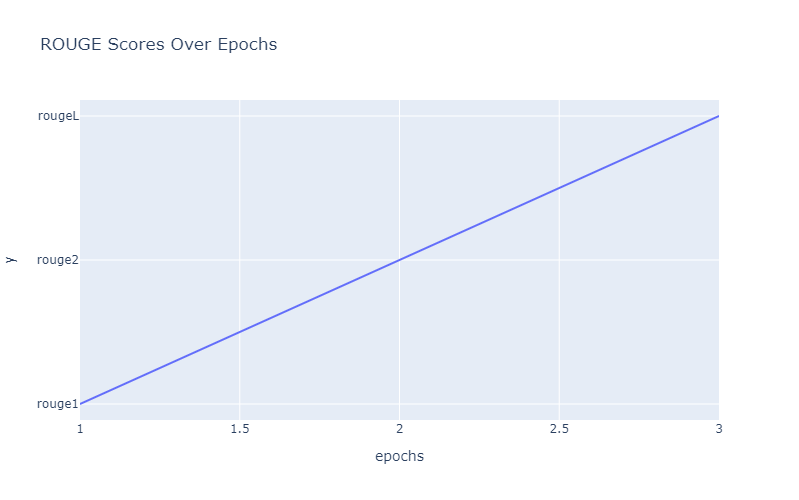

In [28]:
# Assuming you have a DataFrame `df` containing the training history
df = pd.DataFrame(train_history)
df['epochs'] = range(1, len(df) + 1)

# Plotting ROUGE scores over epochs
fig = px.line(df, x='epochs', y=['rouge1', 'rouge2', 'rougeL'],
              labels={'value': 'F1 Score', 'variable': 'ROUGE Metric'},
              title='ROUGE Scores Over Epochs',
              width=800, height=500)

fig.show()

In [36]:
# Print ROUGE scores for each epoch
for index, row in df.iterrows():
    print(f"Epoch {row['Epoch']}:")
    print(f"  ROUGE-1 = {row['Rouge1']}")
    print(f"  ROUGE-2 = {row['Rouge2']}")
    print(f"  ROUGE-L = {row['Rougel']}")

Epoch 0:
  ROUGE-1 = 24.7698
  ROUGE-2 = 33.5795
  ROUGE-L = 33.5108
Epoch 1:
  ROUGE-1 = 42.2049
  ROUGE-2 = 24.7309
  ROUGE-L = 33.7859
Epoch 2:
  ROUGE-1 = 43.1892
  ROUGE-2 = 25.8581
  ROUGE-L = 34.7
Epoch 3:
  ROUGE-1 = 42.7761
  ROUGE-2 = 25.4726
  ROUGE-L = 34.2199


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Générer les résumés des données</div>

In [37]:
# Generate summary
input_text="By . Emma Innes . A cystic fibrosis patient has married his girlfriend after having a successful lung transplant. Dane Pollard, 34, was diagnosed with the condition when he was 18 months old and feared he would not survive. The condition caused his lungs to fill with mucus, meaning he needed daily physiotherapy in order to lead a normal life. Dane Pollard met and married his partner, Emma, after his life was saved by a last minute lung transplant . Mr Pollard was diagnosed with cystic fibrosis when he was 18 months old and his health slowly deteriorated . However, his health worsened and he found himself needing a wheelchair and additional oxygen. He eventually ended up housebound and was put on the lung transplant list. In 2008, he received a call to say that some new lungs had been found for him and the operation could go ahead. He believes that if the lungs had not become available, he would not have survived for many more days."
summary = generate_summary(input_text, model, tokenizer)

# Print the generated summary
print("Input Text:")
print(input_text)
print("\nGenerated Summary:")
print(summary)

Input Text:
By . Emma Innes . A cystic fibrosis patient has married his girlfriend after having a successful lung transplant. Dane Pollard, 34, was diagnosed with the condition when he was 18 months old and feared he would not survive. The condition caused his lungs to fill with mucus, meaning he needed daily physiotherapy in order to lead a normal life. Dane Pollard met and married his partner, Emma, after his life was saved by a last minute lung transplant . Mr Pollard was diagnosed with cystic fibrosis when he was 18 months old and his health slowly deteriorated . However, his health worsened and he found himself needing a wheelchair and additional oxygen. He eventually ended up housebound and was put on the lung transplant list. In 2008, he received a call to say that some new lungs had been found for him and the operation could go ahead. He believes that if the lungs had not become available, he would not have survived for many more days.

Generated Summary:
 cystic fibrosis patie

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Sauvgarder le modèle et le tojenizer</div>

In [38]:
# Save fine-tuned model and tokenizer
model_path = 'ESI_SUM_fine_tuned_model'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('ESI_SUM_fine_tuned_model/tokenizer_config.json',
 'ESI_SUM_fine_tuned_model/special_tokens_map.json',
 'ESI_SUM_fine_tuned_model/vocab.json',
 'ESI_SUM_fine_tuned_model/merges.txt',
 'ESI_SUM_fine_tuned_model/added_tokens.json')

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
archiver le dossier pour le télécharger</div>

In [39]:
# Saving model in .zip format
shutil.make_archive('ESI_SUM_fine_tuned_model', 'zip', '/kaggle/working/ESI_SUM_fine_tuned_model')
shutil.move('ESI_SUM_fine_tuned_model.zip', '/kaggle/working/ESI_SUM_fine_tuned_model.zip')

'/kaggle/working/ESI_SUM_fine_tuned_model.zip'

<h2 style='color:olive' align='center'>Références: </h2>

---
<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
<ul>
<li><a href="https://blog.research.google/2016/08/text-summarization-with-tensorflow.html" style="color:white;"> Ressource 1</a></li>
<li><a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" style="color:white;"> Ressource 2</a></li>
<li><a href="https://www.kaggle.com/datasets/sbhatti/news-summarization/data" style="color:white;"> Ressource 3 </a></li>
<li><a href="https://radimrehurek.com/gensim/models/word2vec.html" style="color:white;"> Ressource4 </a></li>
    
</ul>
</div>

---

<h2 style='color:olive' align='center'>END </h2>